# Imagenet image generation


This notebook contains implementation of a super-resolution network trained on Imagenet.

In [1]:
%matplotlib inline
import importlib
import utils2; importlib.reload(utils2)
from utils2 import *

from scipy.optimize import fmin_l_bfgs_b
from scipy.misc import imsave
from keras import metrics

from vgg16_avg import VGG16_Avg

Using TensorFlow backend.
/home/jhoward/anaconda3/lib/python3.6/site-packages/sklearn/cross_validation.py:44: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


In [2]:
from bcolz_array_iterator import BcolzArrayIterator

In [3]:
limit_mem()

In [4]:
path = '/data/jhoward/imagenet/full/'
dpath = '/data/jhoward/fast/imagenet/full/'

All code is identical to the implementation shown in the neural-style notebook, with the exception of the BcolzArrayIterator and training implementation.

In [5]:
rn_mean = np.array([123.68, 116.779, 103.939], dtype=np.float32)
preproc = lambda x: (x - rn_mean)[:, :, :, ::-1]

In [6]:
deproc = lambda x,s: np.clip(x.reshape(s)[:, :, :, ::-1] + rn_mean, 0, 255)

We can't load Imagenet into memory, so we open the files and then pass them to the generator BcolzArrayIterator.

In [7]:
arr_lr = bcolz.open(dpath+'trn_resized_72_r.bc')
arr_hr = bcolz.open(path+'results/trn_resized_288_r.bc')

In [8]:
parms = {'verbose': 0, 'callbacks': [TQDMNotebookCallback(leave_inner=True)]}

In [9]:
def conv_block(x, filters, size, stride=(2,2), mode='same', act=True):
    x = Convolution2D(filters, size, size, subsample=stride, border_mode=mode)(x)
    x = BatchNormalization(mode=2)(x)
    return Activation('relu')(x) if act else x

In [10]:
def res_block(ip, nf=64):
    x = conv_block(ip, nf, 3, (1,1))
    x = conv_block(x, nf, 3, (1,1), act=False)
    return merge([x, ip], mode='sum')

In [11]:
def up_block(x, filters, size):
    x = keras.layers.UpSampling2D()(x)
    x = Convolution2D(filters, size, size, border_mode='same')(x)
    x = BatchNormalization(mode=2)(x)
    return Activation('relu')(x)

In [12]:
def get_model(arr):
    inp=Input(arr.shape[1:])
    x=conv_block(inp, 64, 9, (1,1))
    for i in range(4): x=res_block(x)
    x=up_block(x, 64, 3)
    x=up_block(x, 64, 3)
    x=Convolution2D(3, 9, 9, activation='tanh', border_mode='same')(x)
    outp=Lambda(lambda x: (x+1)*127.5)(x)
    return inp,outp

In [13]:
inp,outp=get_model(arr_lr)

In [14]:
shp = arr_hr.shape[1:]

vgg_inp=Input(shp)
vgg= VGG16(include_top=False, input_tensor=Lambda(preproc)(vgg_inp))
for l in vgg.layers: l.trainable=False

In [15]:
def get_outp(m, ln): return m.get_layer(f'block{ln}_conv2').output
vgg_content = Model(vgg_inp, [get_outp(vgg, o) for o in [1,2,3]])
vgg1 = vgg_content(vgg_inp)
vgg2 = vgg_content(outp)

In [16]:
def mean_sqr_b(diff): 
    dims = list(range(1,K.ndim(diff)))
    return K.expand_dims(K.sqrt(K.mean(diff**2, dims)), 0)

In [17]:
w=[0.1, 0.8, 0.1]
def content_fn(x): 
    res = 0; n=len(w)
    for i in range(n): res += mean_sqr_b(x[i]-x[i+n]) * w[i]
    return res

In [18]:
m_sr = Model([inp, vgg_inp], Lambda(content_fn)(vgg1+vgg2))
m_sr.compile('adam', 'mae')

Our training implementation has been altered to accomodate the BcolzArrayIterator.

We're unable to use <tt>model.fit_generator()</tt> because that function call expects the generator to return a tuple of inputs and targets.

Our generator however yields two inputs. We can work around this by separately pulling out our inputs from the generator and then using <tt>model.train_on_batch()</tt> with our inputs from the generator and our dummy targets. <tt>model.train_on_batch()</tt> simply does one gradient update on the batch of data.

This technique of creating your own training loop is useful when you are working with various iterators or complicated inputs that don't conform to keras' standard fitting methods.

In [19]:
def train(bs, niter=10):
    targ = np.zeros((bs, 1))
    bc = BcolzArrayIterator(arr_hr, arr_lr, batch_size=bs)
    for i in range(niter):
        hr,lr = next(bc)
        m_sr.train_on_batch([lr[:bs], hr[:bs]], targ)

In [20]:
its = len(arr_hr)//16; its

62277

NOTE: Batch size must be a multiple of chunk length.

In [34]:
%time train(16, 18000)

CPU times: user 2h 22min 35s, sys: 1h 11min 5s, total: 3h 33min 40s
Wall time: 4h 28min 40s


In [35]:
K.set_value(m_sr.optimizer.lr, 1e-4)
train(16, 18000)

In [21]:
top_model = Model(inp, outp)

In [37]:
p = top_model.predict(arr_lr[:20])

In [29]:
new_file = '/data/jhoward/imagenet/full/valid/n01498041/ILSVRC2012_val_00005642.JPEG'

In [35]:
img = Image.open(new_file).resize((288,288))

In [36]:
img_dat = np.expand_dims(np.array(img),0)

Some results after training on ~ half of imagenet:

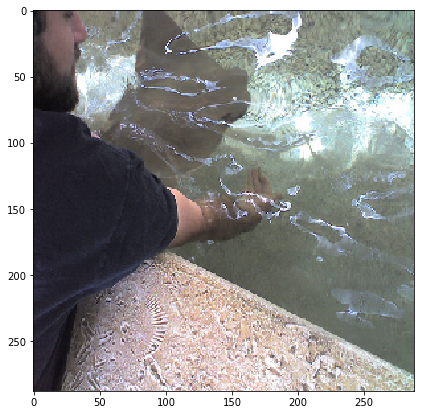

In [42]:
plt.figure(figsize=(7,7))
plt.imshow(img_dat[0]);

In [40]:
p = model_hr.predict(img_dat)

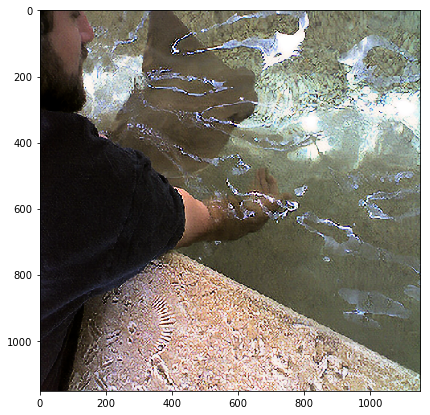

In [43]:
plt.figure(figsize=(7,7))
plt.imshow(p[0].astype('uint8'));

The model is working as expected.

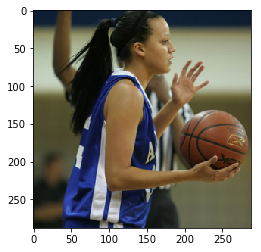

In [53]:
idx=4
plt.imshow(arr_hr[idx].astype('uint8'));

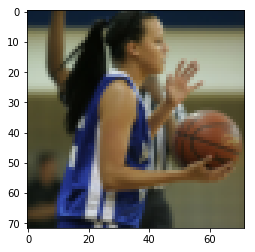

In [54]:
plt.imshow(arr_lr[idx].astype('uint8'));

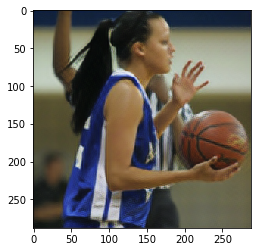

In [55]:
plt.imshow(p[idx].astype('uint8'));

Since the CNN is fully convolutional, we can use it one images of arbitrary size. Let's try it w/ the high-res as the input.

In [39]:
inp,outp=get_model(arr_hr)
model_hr = Model(inp, outp)
copy_weights(top_model.layers, model_hr.layers)

In [78]:
p = model_hr.predict(arr_hr[idx:idx+1])

This quality of this prediction is very impressive given that this model was trained the low res images.

One take away here is that this suggests that the upsampling such a model is learning is somewhat independent of resolution.

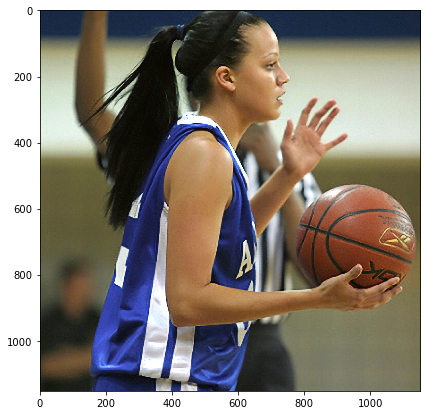

In [81]:
plt.figure(figsize=(7,7))
plt.imshow(p[0].astype('uint8'));

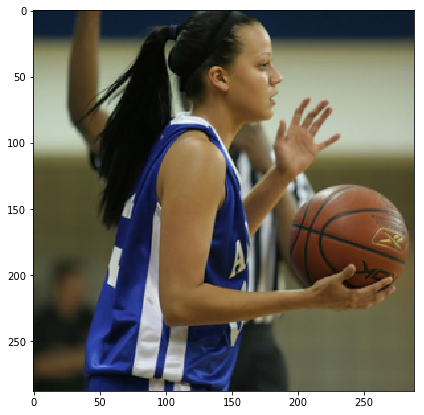

In [82]:
plt.figure(figsize=(7,7))
plt.imshow(arr_hr[idx].astype('uint8'));

In [40]:
top_model.save_weights(dpath+'sr_final.h5')

In [22]:
top_model.load_weights(dpath+'sr_final.h5')